# Home Credit Default Risk - Application Data Exploration


Context:
Millions of people face barriers accessing traditional credit due to limited or non-existent credit history.
Home Credit aims to bridge this gap by using alternative data—like telco and transaction records—to assess loan applicants and promote financial inclusion.

Objective:
In this notebook, we’ll use the `application_train.csv` data to build a model that **predicts the likelihood of a client repaying a loan.** Each row represents one loan application, and the `TARGET` variable indicates repayment status:
- 0 = loan was repaid
- 1 = loan was not repaid

We’ll begin by cleaning and analyzing the application data to build a baseline model. In future notebooks, we’ll integrate additional datasets such as `bureau.csv` and `previous_application.csv` for more advanced modeling.


```python
# Evaluation Metric: ROC-AUC
# ROC-AUC (Receiver Operating Characteristic - Area Under Curve) evaluates how well the model separates positive and negative classes.
# A higher ROC-AUC score indicates better performance in distinguishing between repaid and defaulted loans.
```

In [1]:
import numpy as np
import pandas as pd
# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
app_train_df = pd.read_csv('/content/drive/MyDrive/csv files/application_train.csv')
print("Training data shape: ", app_train_df.shape)
app_train_df.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


The training data has 307511 observations (each one a separate loan) and 122 features (variables) including the TARGET.

In [ ]:
# Testing data features
app_test_df = pd.read_csv('/content/drive/MyDrive/csv files/application_test.csv')
print('Testing data shape: ', app_test_df.shape)
app_test_df.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Testing data has 48744 obserations and 121 features.

# Exploratory Data Analysis

**Examine the Distribution of the Target Column/ class distribution**<br>
The target is either 0 for the loan was repaid on time, or a 1 indicating the client had payment difficulties.

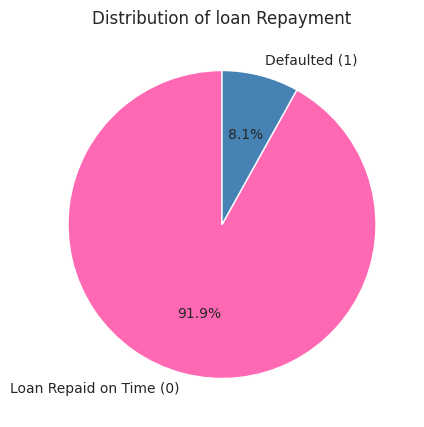

In [ ]:
# Count the values in 'TARGET'
target_counts = app_train_df['TARGET'].value_counts()
# Define labels and colors
labels =['Loan Repaid on Time (0)', 'Defaulted (1)']
colors = ['#FF69B4', '#4682B4']  # Pink and Blue

plt.figure(figsize=(5,5))
plt.pie(target_counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title("Distribution of loan Repayment")
plt.show();

From this information, we see this is an imbalanced class problem. There are far more loans (91.9%) that were repaid on time than loans that were not repaid (8.1%).

**Calculate and plot point biserial correlations between numerical features and the binary target (TARGET)**

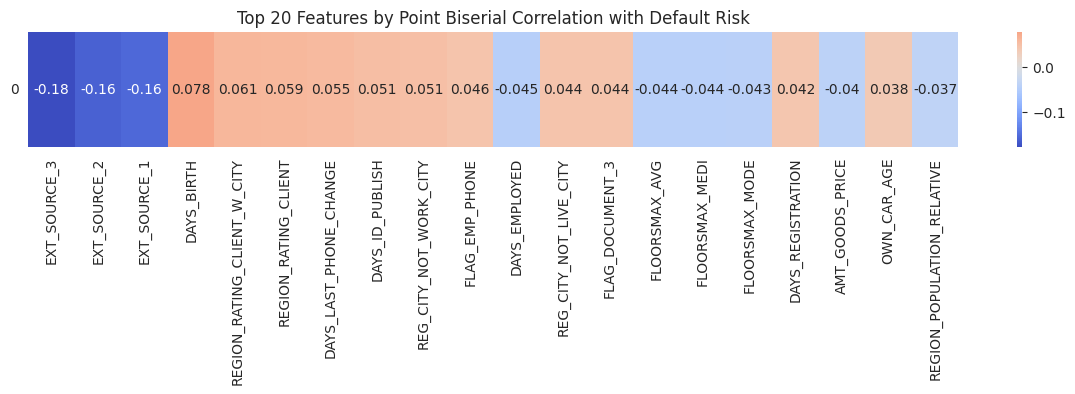

In [ ]:
from scipy.stats import pointbiserialr

# Select numeric features
num_fea = app_train_df.select_dtypes(exclude='object')

# Calculate point biserial correlations
pb_corrs = {}
for col in num_fea.columns:
    if col != 'TARGET':
        valid_idx = app_train_df[col].notna()  # Avoid NaNs
        corr, _ = pointbiserialr(app_train_df.loc[valid_idx, col], app_train_df.loc[valid_idx, 'TARGET'])
        pb_corrs[col] = corr

# Convert to Series and sort
pb_corr_series = pd.Series(pb_corrs).sort_values(key=abs, ascending=False)

# Take top 20
top_pb_corr = pb_corr_series.head(20)

# Convert to DataFrame and transpose for heatmap
top_pb_corr_df = pd.DataFrame(top_pb_corr).T

# Plot
plt.figure(figsize=(15, 1.5))
sns.heatmap(top_pb_corr_df, annot=True, cmap='coolwarm', center=0, cbar=True)
plt.title('Top 20 Features by Point Biserial Correlation with Default Risk')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


*External Sources are highly correlated followed by Days Birth compare to other variables.*

 **class-wise density curves showing distribution of numerical features across different TARGET classes (default and non-default)**

> - Separation between curves → the feature might help in distinguishing good vs. bad credit.
- Overlap → less predictive power individually.<br>
since our curves are overlapping they have less predicitve power individually.
- EXT_SOURCE_3, EXT_SOURCE_2,  has a higher density for TARGET = 0 at higher values, it suggests higher EXT_SOURCE_3, EXT_SOURCE_2 scores are linked to lower credit risk.






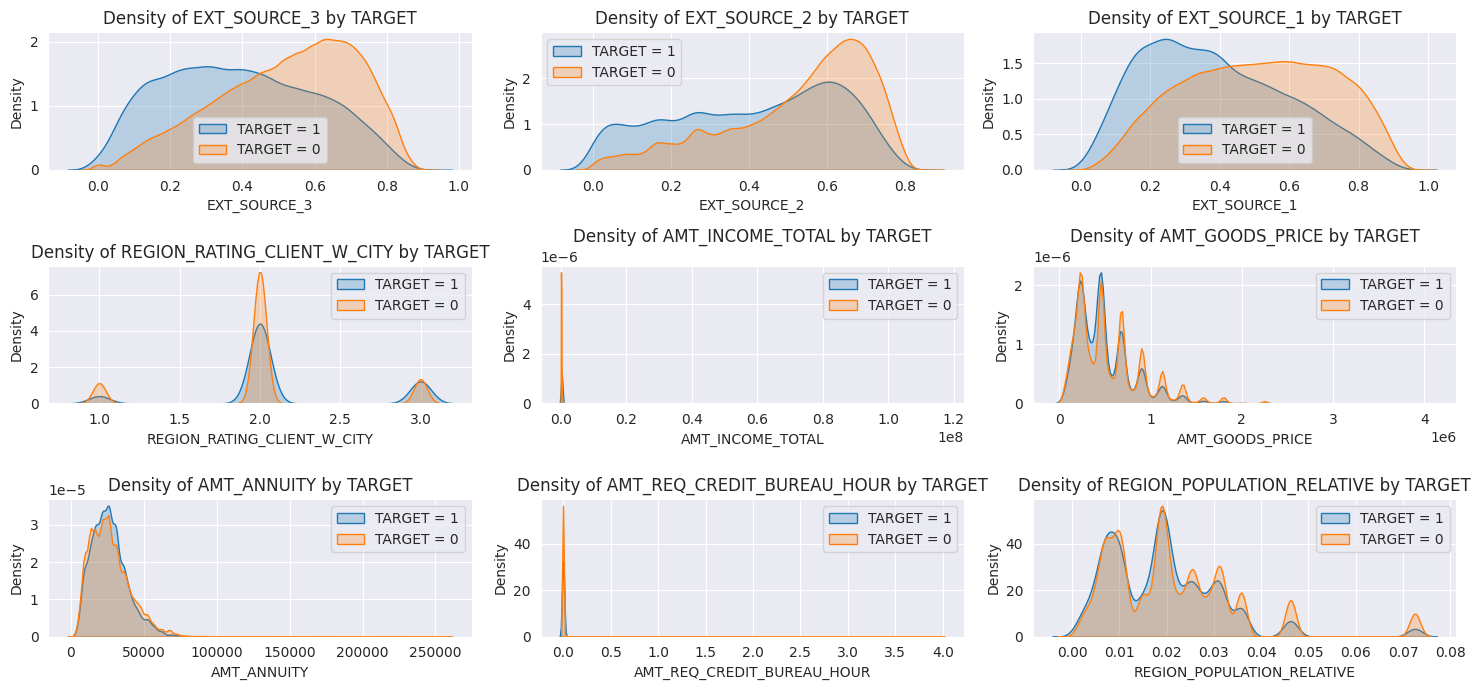

In [ ]:
density_plot_col = ['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1',
                    'REGION_RATING_CLIENT_W_CITY', 'AMT_INCOME_TOTAL','AMT_GOODS_PRICE',
                    'AMT_ANNUITY', 'AMT_REQ_CREDIT_BUREAU_HOUR','REGION_POPULATION_RELATIVE']

# Set up subplot grid
fig, axis = plt.subplots(3, 3, figsize=(15, 7))
axis = axis.flatten()

# Plot class-wise KDEs for each feature
for i, col in enumerate(density_plot_col):
    for target_value in app_train_df['TARGET'].unique():
        subset = app_train_df[app_train_df['TARGET'] == target_value]
        sns.kdeplot(data=subset, x=col, ax=axis[i], label=f'TARGET = {target_value}', fill=True)

    axis[i].set_title(f"Density of {col} by TARGET")
    axis[i].legend()
# Hide any unused subplots
for j in range(i + 1, len(axis)):
    axis[j].set_visible(False)
# Cleanup
plt.tight_layout()
plt.show()

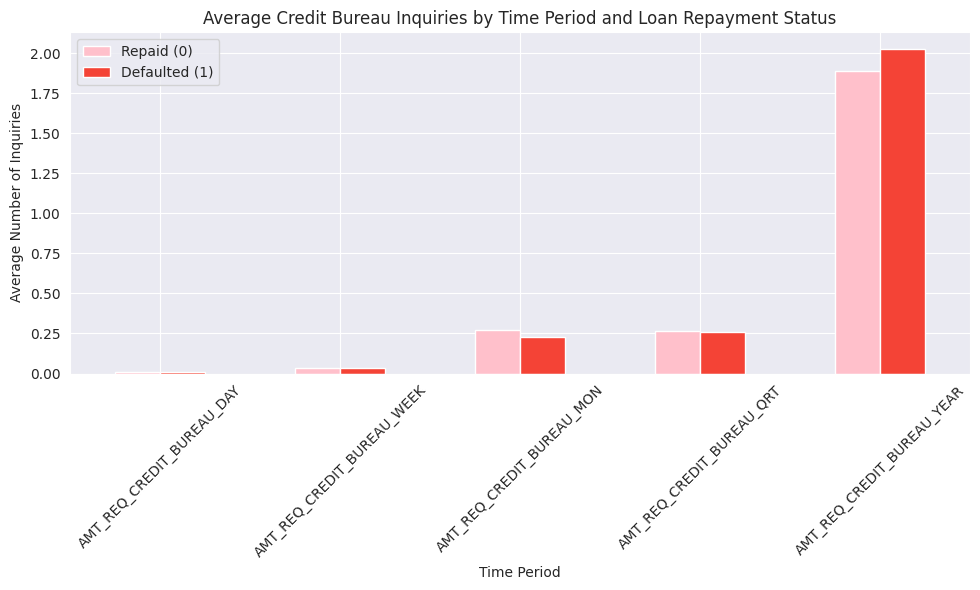

In [ ]:
# List of features
bureau_features = [
    'AMT_REQ_CREDIT_BUREAU_DAY',
    'AMT_REQ_CREDIT_BUREAU_WEEK',
    'AMT_REQ_CREDIT_BUREAU_MON',
    'AMT_REQ_CREDIT_BUREAU_QRT',
    'AMT_REQ_CREDIT_BUREAU_YEAR'
]

# Calculate mean inquiries by TARGET
mean_values = app_train_df.groupby('TARGET')[bureau_features].mean().T
mean_values.columns = ['Repaid (0)', 'Defaulted (1)']

# Plot
mean_values.plot(kind='bar', figsize=(10, 6), color=['pink', '#F44336'])
plt.title('Average Credit Bureau Inquiries by Time Period and Loan Repayment Status')
plt.ylabel('Average Number of Inquiries')
plt.xlabel('Time Period')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This help us explore whether frequent credit bureau checks over different time scales are linked to higher default risk.


([0, 1], [Text(0, 0, 'Cash loans'), Text(1, 0, 'Revolving loans')])

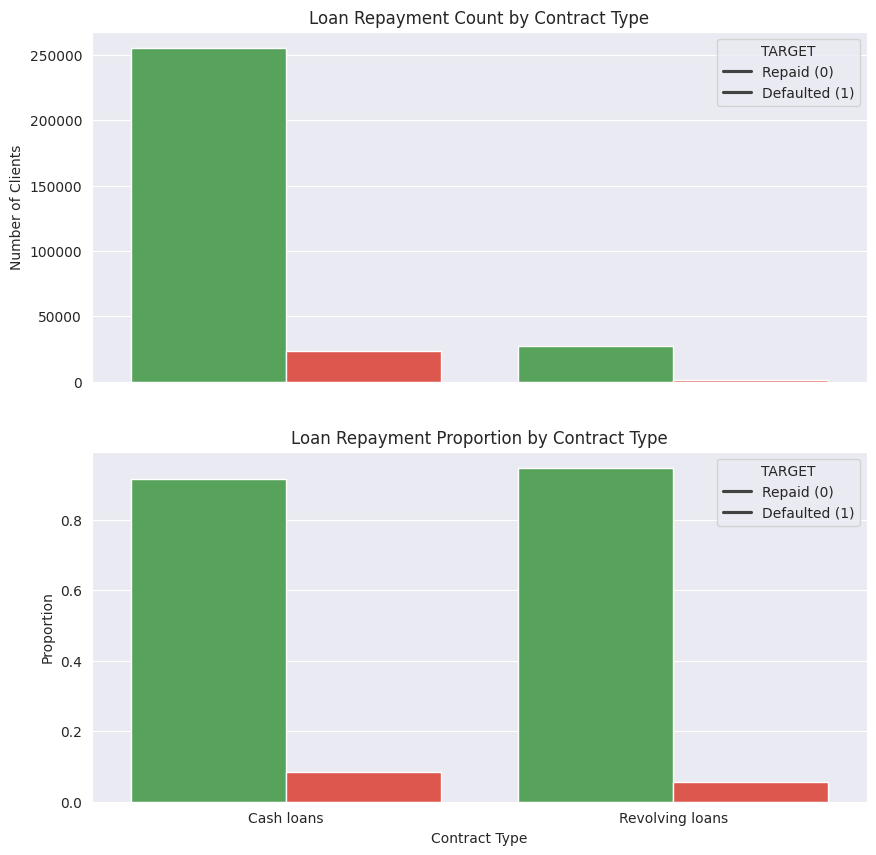

In [ ]:

# --- Absolute count ---
contract_target_count = (
    app_train_df.groupby(['NAME_CONTRACT_TYPE', 'TARGET'])
    .size()
    .rename('Count')
    .reset_index()
)

# --- Proportion (normalized) ---
contract_target_prop = (
    app_train_df.groupby('NAME_CONTRACT_TYPE')['TARGET']
    .value_counts(normalize=True)
    .rename('Proportion')
    .reset_index()
)

# --- Plot both ---
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Absolute count
sns.barplot(
    data=contract_target_count,
    x='NAME_CONTRACT_TYPE',
    y='Count',
    hue='TARGET',
    palette={0: '#4CAF50', 1: '#F44336'},
    ax=axes[0]
)
axes[0].set_title('Loan Repayment Count by Contract Type')
axes[0].set_ylabel('Number of Clients')
axes[0].set_xlabel('')
axes[0].legend(title='TARGET', labels=['Repaid (0)', 'Defaulted (1)'])

# Proportion
sns.barplot(
    data=contract_target_prop,
    x='NAME_CONTRACT_TYPE',
    y='Proportion',
    hue='TARGET',
    palette={0: '#4CAF50', 1: '#F44336'},
    ax=axes[1]
)
axes[1].set_title('Loan Repayment Proportion by Contract Type')
axes[1].set_ylabel('Proportion')
axes[1].set_xlabel('Contract Type')
axes[1].legend(title='TARGET', labels=['Repaid (0)', 'Defaulted (1)'])

# Tidy up
plt.xticks(rotation=0)




>
### Interpretation:

* **Top chart** shows the **absolute number of loans** by contract type and repayment status.
  → It reveals that **Cash loans are far more popular**, and hence, **more defaults** occur simply due to higher volume — **not necessarily because they're riskier**.

* **Bottom chart** shows the **proportion of defaults (normalized within each loan type)**.
  → It indicates the **risk level** of each loan type.
  Even though **Revolving credit** has a **smaller total volume**, it has a **higher default rate**, making it **riskier per loan issued**.







**Who are the target population buying loans more frequently?**


<Axes: xlabel='count', ylabel='OCCUPATION_TYPE'>

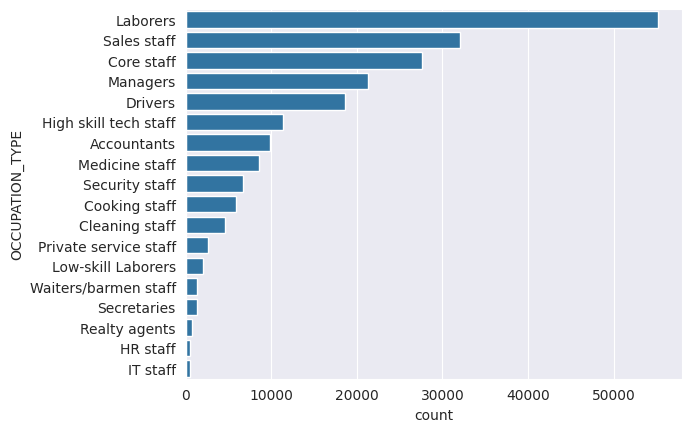

In [ ]:
sns.countplot(y='OCCUPATION_TYPE', data=app_train_df, order=app_train_df['OCCUPATION_TYPE'].value_counts().index)

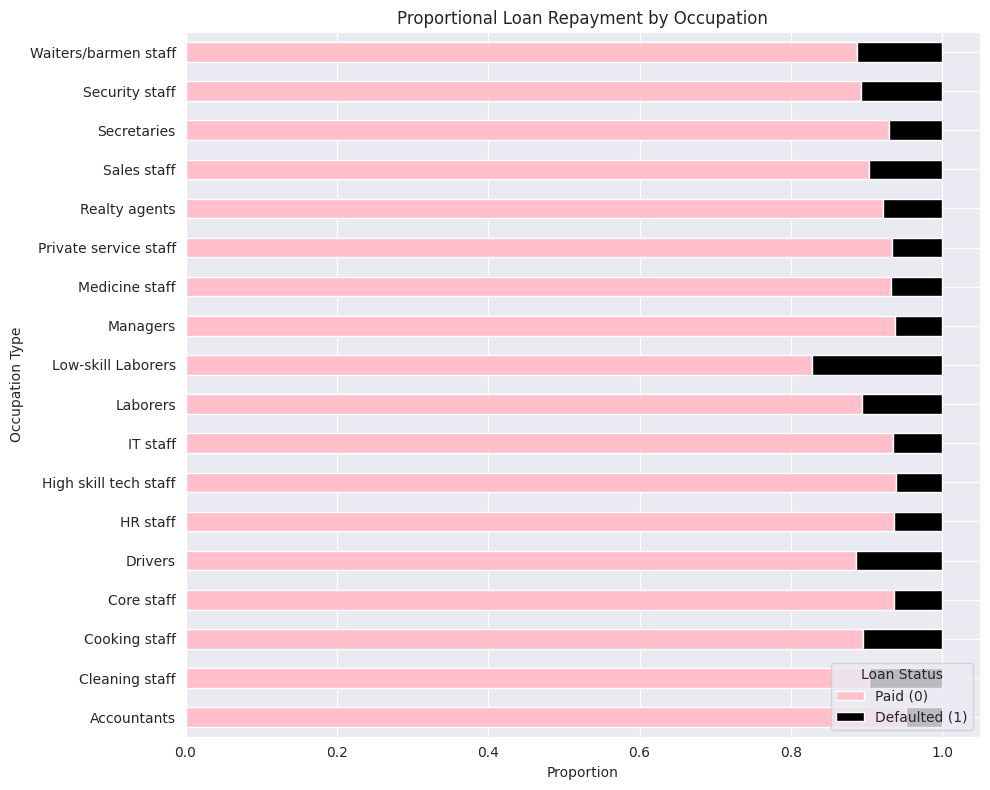

In [9]:
# Group, count, and normalize by row (within each occupation)
prop = (
    app_train_df.groupby(['OCCUPATION_TYPE', 'TARGET'])
    .size()
    .unstack(fill_value=0)
    .apply(lambda x: x / x.sum(), axis=1)
)

# Rename columns for clarity
prop.columns = ['Paid (0)', 'Defaulted (1)']

# Plot horizontal stacked bar chart
prop.plot(
    kind='barh',
    stacked=True,
    figsize=(10, 8),
    color=['pink', 'black']
)

plt.title('Proportional Loan Repayment by Occupation')
plt.ylabel('Occupation Type')
plt.xlabel('Proportion')
plt.legend(title='Loan Status', loc='lower right')
plt.tight_layout()
plt.show()

*Waiters/ bar staff similar to Low-skill labourers (highest default rate) though are less in applying/ getting loans defaulted more*

**spot which education backgrounds dominate different income categories.** i.e how education levels are distributed across different income groups

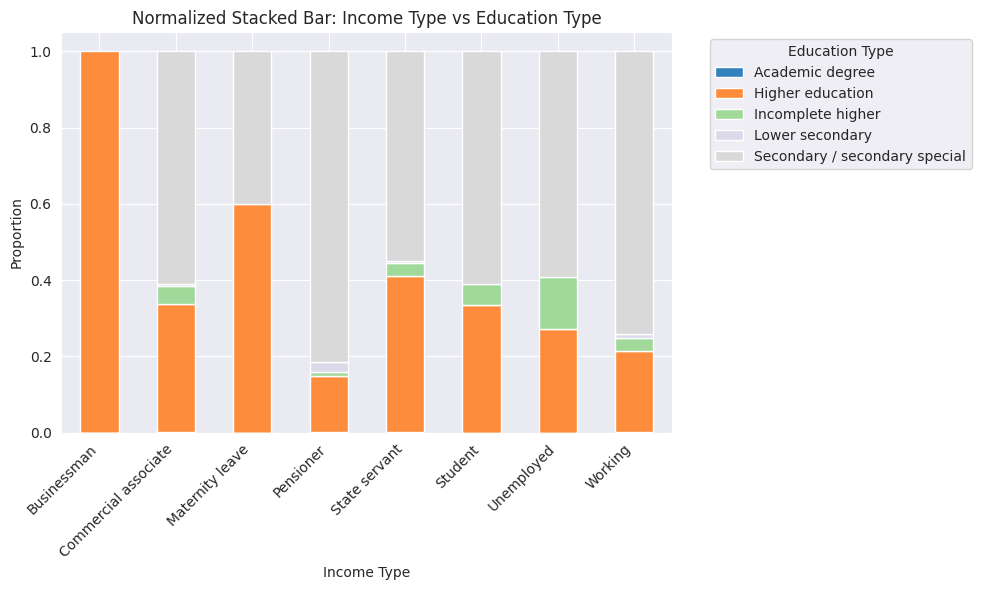

In [ ]:
# Create normalized crosstab
normalized_crosstab = pd.crosstab(
    app_train_df['NAME_INCOME_TYPE'],
    app_train_df['NAME_EDUCATION_TYPE'],
    normalize='index'  # Normalize across income types
)

# Plot
normalized_crosstab.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20c')

plt.title('Normalized Stacked Bar: Income Type vs Education Type')
plt.xlabel('Income Type')
plt.ylabel('Proportion')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Education Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

*Secondary/ Secondary Special is the most prevalent education level in almost every Income Type except the businessman's who have received Higher education*

**heatmaps or pivot tables to summarize defaults across combinations of NAME_HOUSING_TYPE and NAME_FAMILY_STATUS**


<Axes: xlabel='NAME_FAMILY_STATUS', ylabel='NAME_HOUSING_TYPE'>

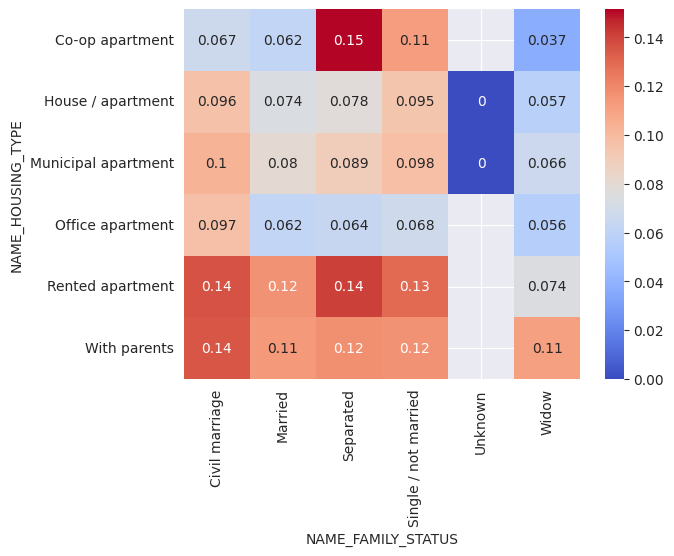

In [ ]:
pivot = pd.pivot_table(app_train_df, values='TARGET', index='NAME_HOUSING_TYPE', columns='NAME_FAMILY_STATUS')
sns.heatmap(pivot, annot=True, cmap='coolwarm')

<Axes: xlabel='CODE_GENDER', ylabel='count'>

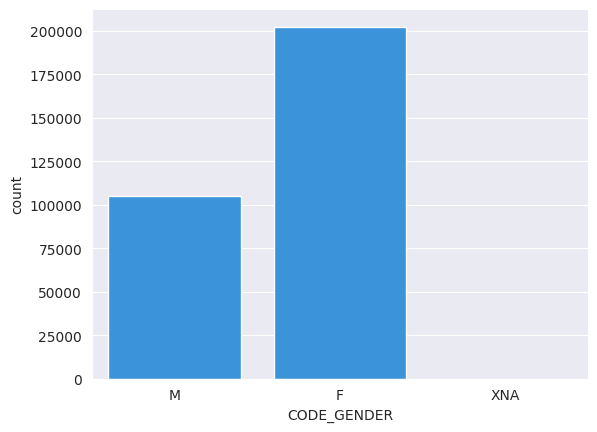

In [5]:
sns.countplot(x='CODE_GENDER',  color= '#2196F3', data=app_train_df)

**Our loan buying population are mostly female**

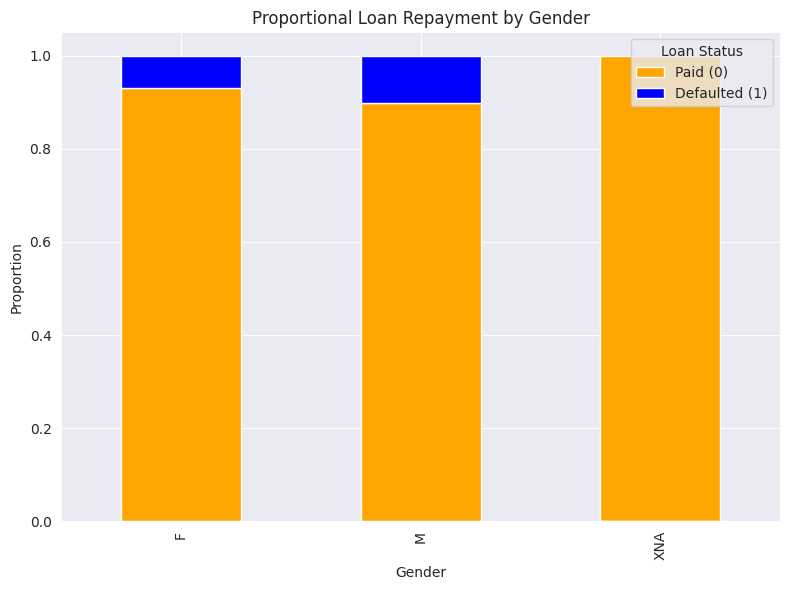

In [4]:
# Group, count, and normalize by row (i.e., within each gender)
prop_data = (
    app_train_df.groupby(['CODE_GENDER', 'TARGET'])
    .size()
    .unstack(fill_value=0)
    .apply(lambda x: x / x.sum(), axis=1)  # Normalize each row
)

# Rename columns for clarity
prop_data.columns = ['Paid (0)', 'Defaulted (1)']

# Plot
prop_data.plot(
    kind='bar',
    stacked=True,
    figsize=(8, 6),
    color=['orange', 'blue']
)

plt.title('Proportional Loan Repayment by Gender')
plt.xlabel('Gender')
plt.ylabel('Proportion')
plt.legend(title='Loan Status', loc='upper right')
plt.tight_layout()
plt.show()


*Among this loan buying population Male are the one who have defaulted more. Female's default ratio in proportion and count to their application is less than male and a gender which is invisible in count plot is actually one who have never defaulted, but this gender is not present in our final test.csv file*

**Missing values**

In [ ]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Combine and name columns directly
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table.columns = ['Missing Values', '% of Total missing Values']

    # Filter and sort
    mis_val_table = mis_val_table[mis_val_table['Missing Values'] > 0]
    mis_val_table = mis_val_table.sort_values('% of Total missing Values', ascending=False)

    print(f"The dataframe has total {df.shape[1]} columns and {mis_val_table.shape[0]} columns with missing values.")
    return mis_val_table

In [ ]:
missing_values = missing_values_table(app_train_df)
missing_values.head(10)

The dataframe has total 122 columns and 67 columns with missing values.


,Missing Values,% of Total missing Values
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_MODE,214865,69.872297
COMMONAREA_AVG,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953


In [ ]:
missing_values.tail(10)

,Missing Values,% of Total missing Values
NAME_TYPE_SUITE,1292,0.420148
DEF_30_CNT_SOCIAL_CIRCLE,1021,0.332021
DEF_60_CNT_SOCIAL_CIRCLE,1021,0.332021
OBS_30_CNT_SOCIAL_CIRCLE,1021,0.332021
OBS_60_CNT_SOCIAL_CIRCLE,1021,0.332021
EXT_SOURCE_2,660,0.214626
AMT_GOODS_PRICE,278,0.090403
AMT_ANNUITY,12,0.003902
CNT_FAM_MEMBERS,2,0.000650
DAYS_LAST_PHONE_CHANGE,1,0.000325




> There are only four columns with a low percentage of missing values, while most have a **huge** number of missing entries. We can impute these values, or alternatively, drop columns with a high percentage of missing data. However, it's difficult to determine in advance whether those columns will be useful for the model. Therefore, we'll retain all columns for now and rely on Recursive Feature Elimination (RFE) to handle them later. In the meantime, we'll focus on imputing the missing values.



In [ ]:
app_train_df.dtypes.value_counts() # Number of each type of column

,count
float64,65
int64,41
object,16


Number of unique classes in each object column and the most frequent ones.

In [ ]:
# app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)
app_train_df.describe(include='object')

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,307511,307511,307511,307511,306219,307511,307511,307511,307511,211120,307511,307511,97216,153214,151170,161756
unique,2,3,2,2,7,8,5,6,6,18,7,58,4,3,7,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
freq,278232,202448,202924,213312,248526,158774,218391,196432,272868,55186,53901,67992,73830,150503,66040,159428


**Anomalies -->**

> These may be due to mis-typed numbers, errors in measuring equipment, or they could be valid but extreme measurements. One way to support anomalies quantitatively is by looking at the statistics of a column using the describe method. The numbers in the DAYS_BIRTH column are negative because they are recorded relative to the current loan application. To see these stats in years, we can mutliple by -1 (or take the absolute) and divide by the number of days in a year  :



In [ ]:
app_train_df.DAYS_BIRTH.describe()

,DAYS_BIRTH
count,307511.000000
mean,-16036.995067
std,4363.988632
min,-25229.000000
25%,-19682.000000
50%,-15750.000000
75%,-12413.000000
max,-7489.000000


In [ ]:
(abs(app_train_df['DAYS_BIRTH'])/365).describe()

,DAYS_BIRTH
count,307511.000000
mean,43.936973
std,11.956133
min,20.517808
25%,34.008219
50%,43.150685
75%,53.923288
max,69.120548


In [ ]:
app_train_df['AGE_YEARS'] = abs(app_train_df['DAYS_BIRTH']) // 365
app_test_df['AGE_YEARS'] = abs(app_test_df['DAYS_BIRTH']) // 365

In [ ]:
app_train_df['AGE_YEARS'].unique()

array([25, 45, 52, 54, 46, 37, 51, 55, 39, 27, 36, 38, 23, 35, 26, 48, 31,
       50, 40, 30, 68, 43, 28, 41, 32, 33, 47, 57, 65, 44, 64, 21, 59, 49,
       56, 62, 53, 42, 29, 67, 63, 61, 58, 60, 34, 22, 24, 66, 69, 20])

In [ ]:
app_train_df.drop(columns=['DAYS_BIRTH'], axis=1, inplace=True)
app_test_df.drop(columns=['DAYS_BIRTH'], axis=1, inplace=True)

Effect of Age on Repayment

In [ ]:
#  Find the correlation of age_years with target
app_train_df['AGE_YEARS'].corr(app_train_df['TARGET'])

np.float64(-0.07823418202684651)

As the client gets older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time more often. Lets visualize it!

In [ ]:
app_train_df['AGE_YEARS'].min(), app_train_df['AGE_YEARS'].max()

(20, 69)

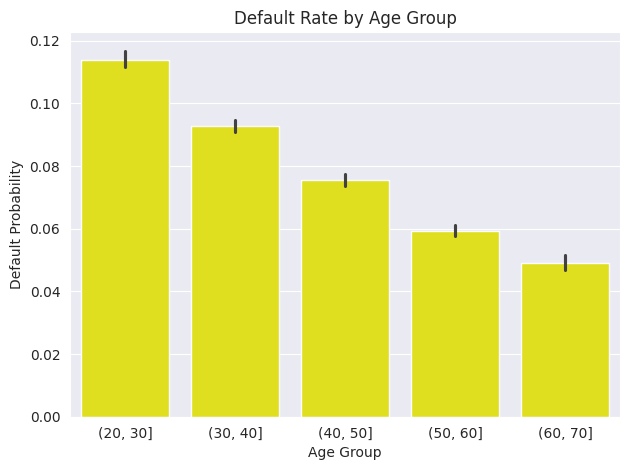

In [ ]:
# Create age bins
app_train_df['AGE_BIN'] = pd.cut(app_train_df['AGE_YEARS'], bins=[20, 30, 40, 50, 60, 70])

# Plot default rate by age bin
sns.barplot(x='AGE_BIN', y='TARGET', data=app_train_df, color='yellow')
plt.title('Default Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Default Probability')
plt.tight_layout()
plt.show()


Anything we do to the training data we also have to do to the testing data, so create age_bin column.

In [ ]:
# create age bins for test set too
app_test_df['AGE_BIN'] = pd.cut(app_test_df['AGE_YEARS'], bins=[20, 30, 40, 50, 60, 70])

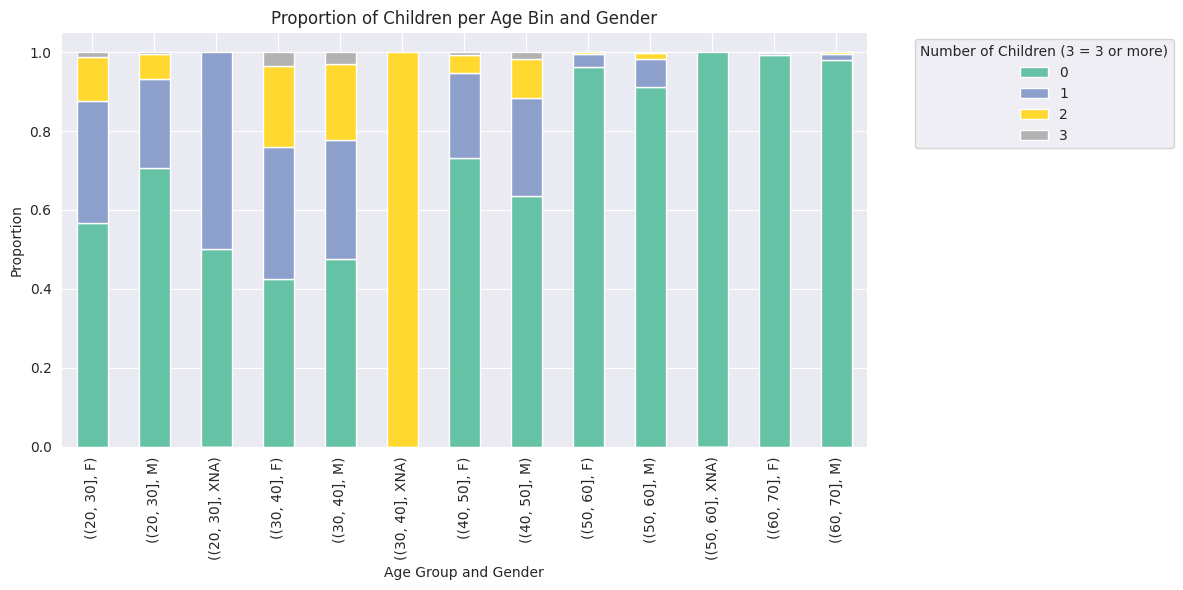

In [ ]:

# For simplicity, clip high number of children (to avoid too many small categories)
app_train_df['CNT_CHILDREN_BIN'] = app_train_df['CNT_CHILDREN'].clip(upper=3)  # 3 means 3 or more

# Group and normalize
grouped = app_train_df.groupby(['AGE_BIN', 'CODE_GENDER', 'CNT_CHILDREN_BIN']).size().reset_index(name='Count')
total_per_group = grouped.groupby(['AGE_BIN', 'CODE_GENDER'])['Count'].transform('sum')
grouped['Proportion'] = grouped['Count'] / total_per_group

# Pivot for stacked bar plot
pivot_df = grouped.pivot_table(index=['AGE_BIN', 'CODE_GENDER'], columns='CNT_CHILDREN_BIN', values='Proportion', fill_value=0)

# Plot
pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2')
plt.title('Proportion of Children per Age Bin and Gender')
plt.xlabel('Age Group and Gender')
plt.ylabel('Proportion')
plt.legend(title='Number of Children (3 = 3 or more)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

DAYS_EMPLOYED = 365243 (≈ 1000 years) is used as a placeholder for unemployed individuals. It's used as a flag to indicate the person is currently unemployed. We can either Replace 365243 with NaN or a flag.

In [ ]:
app_train_df['DAYS_EMPLOYED'].min(), app_train_df.DAYS_EMPLOYED.max()

(-17912, 365243)

**Use a binary flag + keep NaN**<br>
DAYS_EMPLOYED = 365243 is a placeholder for unemployed applicants.

Replacing it with NaN helps us treat it as a missing value, but that doesn't mean it's truly "missing" — it's intentionally informative.

so by using binary flag and then imputing it would not introduce bias.

In [ ]:
# create a flag for anomaly -- employed and unemployed
app_train_df['DAYS_EMPLOYED_ANOM'] = app_train_df['DAYS_EMPLOYED'] == 365243
app_test_df['DAYS_EMPLOYED_ANOM'] = app_test_df['DAYS_EMPLOYED'] == 365243

# Replace anomaly (365243) with nan
app_train_df['DAYS_EMPLOYED'] = app_train_df['DAYS_EMPLOYED'].replace(365243,np.nan)
app_test_df['DAYS_EMPLOYED'] = app_test_df['DAYS_EMPLOYED'].replace(365243, np.nan)


Now, DAYS_EMPLOYED_ANOM becomes a useful binary feature (like a flag for unemployed).

DAYS_EMPLOYED is properly treated as having missing values, which will impute.

Note: Always handle domain-specific anomalies before feature selection so your model can learn meaningful patterns.

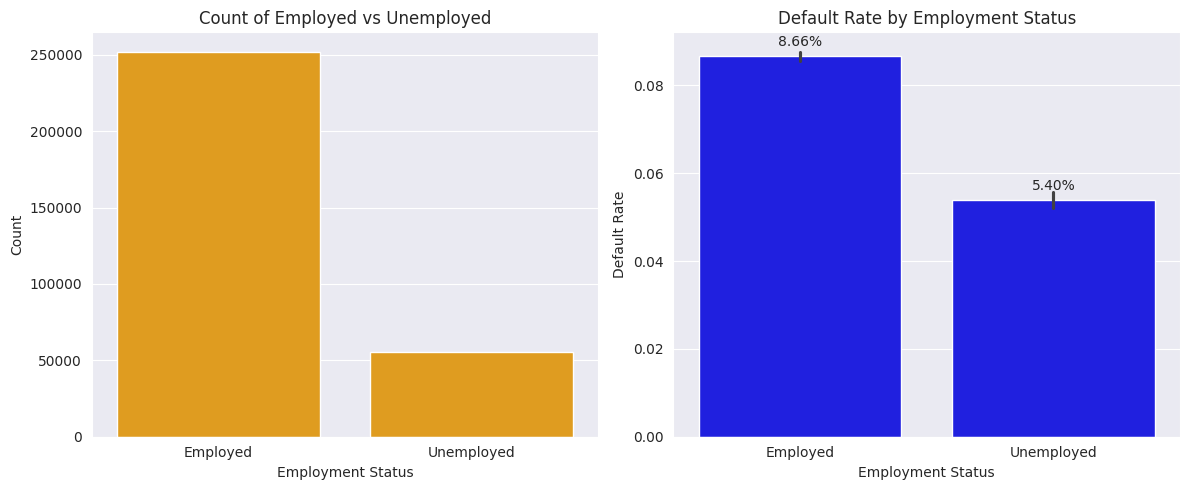

In [ ]:

# Create labeled variable inline
employment_status = app_train_df['DAYS_EMPLOYED_ANOM'].replace({True: 'Unemployed', False: 'Employed'})

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Count plot
sns.countplot(x=employment_status, ax=ax[0], color='orange')
ax[0].set_title('Count of Employed vs Unemployed')
ax[0].set_xlabel('Employment Status')
ax[0].set_ylabel('Count')

# Default rate plot
sns.barplot(
    x=employment_status,
    y=app_train_df['TARGET'],
    ax=ax[1], color='blue',
    estimator=lambda x: sum(x) / len(x)
)
# Add percentages on bars in the second plot only
for bar in ax[1].containers[0]:
    height = bar.get_height()
    ax[1].annotate(f'{height * 100:.2f}%',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 5),
                   textcoords='offset points',
                   ha='center', va='bottom', fontsize=10)

ax[1].set_title('Default Rate by Employment Status')
ax[1].set_xlabel('Employment Status')
ax[1].set_ylabel('Default Rate')

plt.tight_layout()
plt.show()


In [ ]:
summary = app_train_df.groupby(app_train_df['DAYS_EMPLOYED_ANOM'].replace({True: 'Unemployed', False: 'Employed'})) \
    .agg(Count=('TARGET', 'size'), Defaults=('TARGET', 'sum')) \
    .assign(Default_Rate=lambda df: (df['Defaults'] / df['Count']) * 100)
print(summary)


                     Count  Defaults  Default_Rate
DAYS_EMPLOYED_ANOM                                
Employed            252137     21835      8.659975
Unemployed           55374      2990      5.399646


## Detect Train-Test Category Mismatch

It is always a good and safe practice to check whether the categorical columns in the training set have the same categories in the test set as well.

I learned about inconsistencies in the categorical variable values between the train and test sets from this notebook by Will Koehrsen:  
https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction

Later, I used the code below to perform this check.


In [ ]:
cat_cols = app_train_df.select_dtypes(include='object').columns
for col in cat_cols:
    train_vals = set(app_train_df[col].dropna().unique())
    test_vals = set(app_test_df[col].dropna().unique())
    diff = train_vals - test_vals
    if diff:
        print(f"Test set is missing categories in column '{col}': {diff}")


Test set is missing categories in column 'CODE_GENDER': {'XNA'}
Test set is missing categories in column 'NAME_INCOME_TYPE': {'Maternity leave'}
Test set is missing categories in column 'NAME_FAMILY_STATUS': {'Unknown'}


Since we know the training set contains categories that don't exist in the test set, we will address this issue later.<br> Two approaches are possible: <br>
1) using oneHotEncoder with handle_unknow= 'ignore'. It safely ignores unknown categories in test and ensures, all encoded outputs have consistent number and order of columns <br>
2) We can go for for manual column alignment. This is what will use in this notebook




> For the time being, we want to perform Recursive Feature Elimination (RFE), so we’ll impute and encode the categorical variables using `LabelEncoder`.

We are using `LabelEncoder` because Random Forest and LightGBM can handle ordinal encoded values, and we want to avoid one-hot encoding to prevent increasing dimensionality and computation time. At this stage, our goal is to quickly identify important features.








> Handling missing values using -999 for numerical and 'missing' for categorical columns.<br> The placeholder -999 for numeric and 'missing' for categorical won't bias tree based algorithm too heavily but switching to other imputation strategy is better.



## Recursive Feature Elimination for Feature Selection

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier


# Copy dataset
sample_df = app_train_df.copy()

# Separate target
X = sample_df.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = sample_df['TARGET']

# Step 1: Handle missing values with placeholders
for col in X.columns:
    if X[col].dtype == 'object' or X[col].dtype.name =="category" :
      X[col] = X[col].astype(str) # convert to string why? pd.cut() produces a Categorical column, it throws an error.

      X[col].fillna('missing', inplace=True)
    else:
        X[col].fillna(-999, inplace=True)

# Step 2: Encode categorical columns (Label Encoding)
label_encoders = {}
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le  # Store encoder if needed later

# Step 3: Feature selection using RFECV
print(f"Starting with {X.shape[1]} features")

#rf = RandomForestClassifier(n_estimators=100, random_state=42)
lgbm = LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1)
selector = RFECV(estimator=lgbm,
                 step=10,
                 cv=StratifiedKFold(2),
                 scoring='roc_auc',
                 n_jobs=-1)

selector.fit(X, y)

print(f"Optimal number of features: {selector.n_features_}")
selected_features = X.columns[selector.support_].to_list()
print(f"Selected features: {selected_features}")


Starting with 121 features
[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.220913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11148
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 117
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.328475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11132
[LightGBM] [Info] Number of data points in the train set: 307511, number of us

When I used `RandomForestClassifier` with `RFECV`, it ran for over 2 hours (around 2 hrs 30 mins) before being automatically interrupted. In contrast, using LightGBM with RFECV completed in just 10–15 minutes and successfully selected the important features — such a significant speed difference!

`RFECV` with Random Forest on a large dataset (300,000+ rows and 200+ features) is **computationally expensive**, often taking hours or even failing due to resource constraints.

Also, I initially used `step=1` in RFECV, which means the algorithm evaluates the removal of one feature at a time — very slow. Switching to `step=10` allows it to remove 10 features at once, making the process approximately 10x faster.

✅ **Summary**:  
- **Random Forest** was too slow for RFECV on a large dataset.  
- ✅ Switched to **LightGBM**, which is much faster and more efficient for large-scale feature selection.


## visualize performance vs feature
RFECV stores cross-validation scores. visualize the average ROC AUC across folds for each number of selected features.

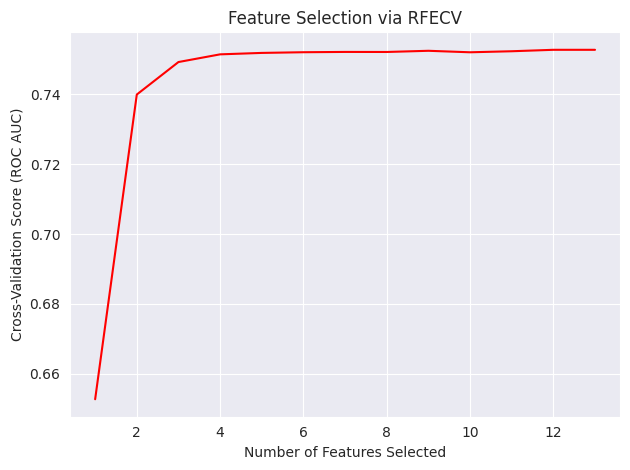

In [ ]:
plt.figure()
plt.plot(range(1, len(selector.cv_results_['mean_test_score']) + 1),
         selector.cv_results_['mean_test_score'], color='red')
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-Validation Score (ROC AUC)")
plt.title("Feature Selection via RFECV")
plt.tight_layout()
plt.show()

### Note on Preprocessing Before Train/Validation Split

In most machine learning workflows, the standard practice is to:

- **First** split the data into training and validation sets
- **Then** perform imputation and encoding using only the training data
- This is done to avoid **data leakage**, where information from the validation/test set influences the model training

---

###  Why Imputation is Done Before Splitting in This Project

In this project, we intentionally perform **imputation before splitting** the data into training and validation sets. Here's why this is acceptable:

- We use **constant-value imputation**:
  - `-999` for missing numerical values
  - `'missing'` for missing categorical values
- These are not data-driven (e.g., mean or mode), so **no information is learned from the data**, and therefore **no data leakage** occurs.

---

###  Why Encoding is Done Before Splitting

We use **`pd.get_dummies()`** for one-hot encoding, which:
- Generates a separate column for each category in the dataset
- Will produce **different numbers of columns** in train and test if any category appears in one and not the other

To solve this, we:
- Perform encoding **before splitting**
- Then **align train and test dataframes**




In [ ]:
app_train = app_train_df[['SK_ID_CURR', 'TARGET'] + selected_features].copy()
app_test = app_test_df[['SK_ID_CURR'] + selected_features].copy()

# Separate numeric and categorical columns
num_cols = app_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = app_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Exclude ID and TARGET
num_cols = [col for col in num_cols if col not in ['SK_ID_CURR', 'TARGET']]

# Apply imputation
for col in num_cols:
    app_train[col].fillna(-999, inplace=True)
    app_test[col].fillna(-999, inplace=True)

for col in cat_cols:
    app_train[col].fillna('missing', inplace=True)
    app_test[col].fillna('missing', inplace=True)


In [ ]:
print("Train NA count:")
print(app_train.isna().sum().sort_values(ascending=False).head())

print("\nTest NA count:")
print(app_test.isna().sum().sort_values(ascending=False).head())


Train NA count:
SK_ID_CURR            0
TARGET                0
NAME_CONTRACT_TYPE    0
CODE_GENDER           0
FLAG_OWN_CAR          0
dtype: int64

Test NA count:
SK_ID_CURR            0
NAME_CONTRACT_TYPE    0
CODE_GENDER           0
FLAG_OWN_CAR          0
FLAG_OWN_REALTY       0
dtype: int64


In [ ]:
app_train.select_dtypes(include='object').columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

In [ ]:
app_test.select_dtypes(include='object').columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

In [ ]:
test_id = app_test['SK_ID_CURR']
app_test.drop('SK_ID_CURR',axis=1, inplace=True)

In [ ]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

In [ ]:
print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 238)


### Aligning Training and Testing Data
There need to be the same features (columns) in both the training and testing data. One-hot encoding has created more columns in the training data because there were some categorical variables with categories not represented in the testing data. To remove the columns in the training data that are not in the testing data, we need to align the dataframes. First we extract the target column from the training data (because this is not in the testing data but we need to keep this information). When we do the align, we must make sure to set axis = 1 to align the dataframes based on the columns and not on the rows!

In [ ]:
train_labels = app_train['TARGET']
# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join='inner', axis=1)


In [ ]:
# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 239)
Testing Features shape:  (48744, 238)


In [ ]:
app_train.columns

Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       ...
       'ORGANIZATION_TYPE_XNA', 'WALLSMATERIAL_MODE_Block',
       'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic',
       'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel',
       'WALLSMATERIAL_MODE_Stone, brick', 'WALLSMATERIAL_MODE_Wooden',
       'WALLSMATERIAL_MODE_missing', 'TARGET'],
      dtype='object', length=202)

The training and testing datasets now have the same features which is required for machine learning.

# Imbalanced dataset: Stratify technique

In [ ]:
from sklearn.model_selection import train_test_split

X = app_train.drop(columns=['TARGET'], axis=1)
y = app_train['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size =0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((246008, 238), (61503, 238), (246008,), (61503,))

In [ ]:
X_train.isna().sum().sum()

np.int64(0)

### Special Characters Matter!

While running LightGBM, I encountered the following error:<br>
LightGBMError: Do not support special JSON characters in feature name.

This means that some **feature names (i.e., column names)** contain special characters or punctuation that are **not allowed** in LightGBM’s internal JSON-based model saving format.

---

###  Why does this happen?

LightGBM is strict about this because it **stores model metadata using JSON**, and JSON doesn't allow certain characters like:


This includes:
- Parentheses `()`
- Quotes `"`
- Colons `:`
- Other special characters

---

###  How did I confirm this?

I ran a validation script and confirmed that some column names contained such special characters.

To fix this:
- I used **regular expressions (`re.sub`)** to clean the column names
- Removed or replaced special characters to make them **LightGBM-safe**

---

###  Even XGBoost can raise issues

Although not as strict as LightGBM, **XGBoost** can also throw errors or behave unpredictably with special characters in feature names — especially during model saving or interpretation.

---

### Which libraries work fine with special characters?

- **Scikit-learn models** (like `LogisticRegression`, `RandomForestClassifier`):
  - These do **not depend on feature names**
  - They operate on NumPy arrays internally
  - No issues with special characters

- **Keras / TensorFlow models**:
  - Input is typically a NumPy array or DataFrame
  -  Feature names are irrelevant unless explicitly used in explanation tools
  -  JSON saving works fine

---

###  Conclusion

> If you're using LightGBM or XGBoost, it's best practice to sanitize column names using regex to avoid hidden errors related to special characters.


In [ ]:
for col in X_train.columns:
    if any(char in col for char in '{}[]":,'):
        print(col)


NAME_TYPE_SUITE_Spouse, partner
ORGANIZATION_TYPE_Industry: type 1
ORGANIZATION_TYPE_Industry: type 10
ORGANIZATION_TYPE_Industry: type 11
ORGANIZATION_TYPE_Industry: type 12
ORGANIZATION_TYPE_Industry: type 13
ORGANIZATION_TYPE_Industry: type 2
ORGANIZATION_TYPE_Industry: type 3
ORGANIZATION_TYPE_Industry: type 4
ORGANIZATION_TYPE_Industry: type 5
ORGANIZATION_TYPE_Industry: type 6
ORGANIZATION_TYPE_Industry: type 7
ORGANIZATION_TYPE_Industry: type 8
ORGANIZATION_TYPE_Industry: type 9
ORGANIZATION_TYPE_Trade: type 1
ORGANIZATION_TYPE_Trade: type 2
ORGANIZATION_TYPE_Trade: type 3
ORGANIZATION_TYPE_Trade: type 4
ORGANIZATION_TYPE_Trade: type 5
ORGANIZATION_TYPE_Trade: type 6
ORGANIZATION_TYPE_Trade: type 7
ORGANIZATION_TYPE_Transport: type 1
ORGANIZATION_TYPE_Transport: type 2
ORGANIZATION_TYPE_Transport: type 3
ORGANIZATION_TYPE_Transport: type 4
WALLSMATERIAL_MODE_Stone, brick


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.base import clone

def evaluate_models_with_roc(models, X_train, y_train, X_test, y_test):
    plt.figure(figsize=(10, 7))
    best_score = -1
    best_model_name = None
    best_model = None

    print("ROC-AUC Scores:")
    for name, model in models.items():
        clf = clone(model)
        clf.fit(X_train, y_train)
        if hasattr(clf, "predict_proba"):
            y_pred_prob = clf.predict_proba(X_test)[:, 1]
        else:
            y_pred_prob = clf.decision_function(X_test) # - Some models don’t have predict_proba() (e.g., SVM), so we fall back on decision_function().

        score = roc_auc_score(y_test, y_pred_prob)
        print(f"{name}: {score:.4f}")
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {score:.2f})")

        if score > best_score:
            best_score = score
            best_model_name = name
            best_model = clf

    # Add plot styling
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    print(f"\nBest model: {best_model_name} with ROC-AUC: {best_score:.4f}")
    y_best_pred = best_model.predict(X_test)
    return best_model, y_best_pred

ROC-AUC Scores:
Logistic Regression: 0.6062
Decision Tree: 0.7016
Random Forest: 0.7298
Extra Trees: 0.6526


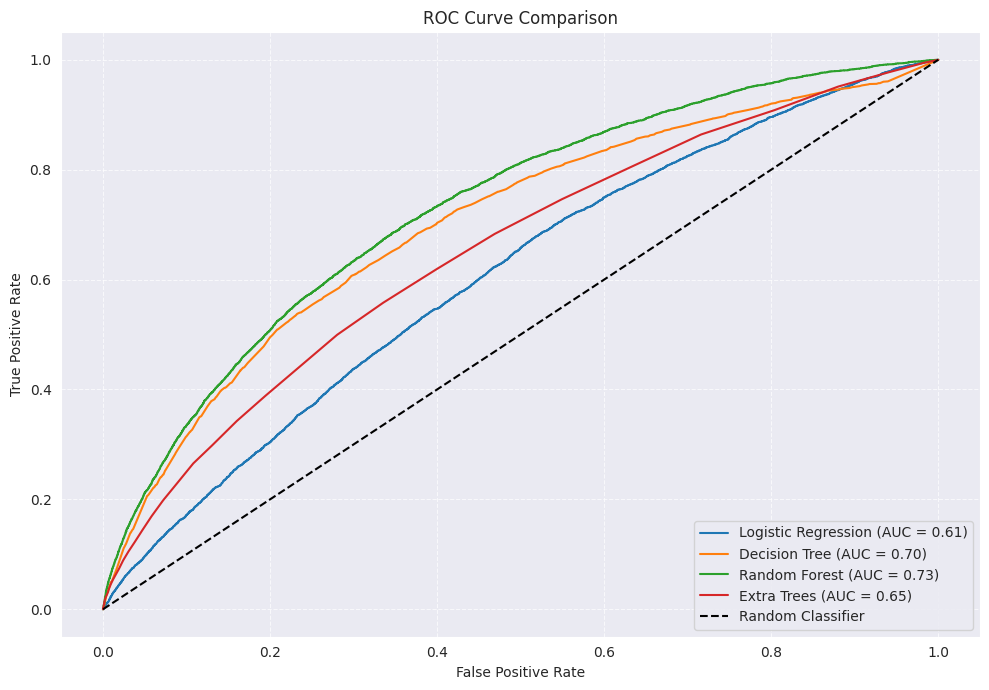


Best model: Random Forest with ROC-AUC: 0.7298


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

models = {
    "Logistic Regression": LogisticRegression(),

    "Decision Tree": DecisionTreeClassifier(**{'min_samples_split': 15, 'min_samples_leaf': 15,
                                  'max_depth': 10, 'class_weight': 'balanced'}),

    "Random Forest": RandomForestClassifier(**{'n_estimators': 200, 'min_samples_split': 20,
                               'min_samples_leaf': 10, 'max_features': 10,
                               'max_depth': 30, 'class_weight': 'balanced', 'bootstrap': True}),

    "Extra Trees": ExtraTreesClassifier()
}

best_model, best_pred = evaluate_models_with_roc(models, X_train, y_train, X_test, y_test)

## Now lets prepare our data for LightGBM and XGBOOST format (non-json)

In [ ]:
import re
def clean_column_names(df):
   df.columns = [re.sub('[^A-Za-z0-9_]+', '_', col) for col in df.columns]
   return df

X_train = clean_column_names(X_train)
X_test = clean_column_names(X_test)
app_test = clean_column_names(app_test)

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import make_scorer, roc_auc_score
# import lightgbm as lgb

# param_dist = {
#     'n_estimators': [300,500,700,1000,1200],
#     'num_leaves': [31, 63, 127],
#     'max_depth': [3, 5, 7, 10],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'min_child_samples': [10, 20, 50],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'reg_alpha': [0, 0.1, 0.5],
#     'reg_lambda': [0, 0.1, 0.5]
# }

# model = lgb.LGBMClassifier( random_state=42)

# search = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=param_dist,
#     n_iter=30,
#     scoring='roc_auc',
#     cv=3,
#     verbose=1,
#     n_jobs=-1
# )

# search.fit(X_train, y_train)
# print("Best AUC:", search.best_score_)
# print("Best Params:", search.best_params_)

LightGBM standalone is super fast (around 5 minutes), but when used with RandomizedSearch, the time complexity increases significantly (it was running for around 1 hour), so I skipped it for now.

In [ ]:
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

model_1 = lgb.LGBMClassifier(n_estimators=1000, learning_rate=0.01, reg_alpha=0.1,
                           random_state=42)

model_1.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train)],
    eval_metric='auc',
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(50)  # show eval every 50 rounds
    ]
)


[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.205516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11248
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 231
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.728946	training's binary_logloss: 0.264492
[100]	training's auc: 0.737506	training's binary_logloss: 0.25743
[150]	training's auc: 0.744765	training's binary_logloss: 0.253327
[200]	training's auc: 0.751016	training's binary_logloss: 0.250527
[250]	training's auc: 0.756596	training's binary_logloss: 0.248405
[300]	training's auc: 0.76117	training's bin

LGBMClassifier(learning_rate=0.01, n_estimators=1000, random_state=42,
               reg_alpha=0.1)

In [ ]:
y_pred = model_1.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_pred)
print("Validation ROC AUC:", roc_auc)

Validation ROC AUC: 0.7620078388758097


In [ ]:

model_2 = lgb.LGBMClassifier(n_estimators=1200, learning_rate=0.05, reg_alpha=0.5,reg_lambda=0.5,
                           random_state=42)

model_2.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train)],
    eval_metric='auc',
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(50)  # show eval every 50 rounds
    ]
)


[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.202152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11248
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 231
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.755961	training's binary_logloss: 0.248421
[100]	training's auc: 0.773992	training's binary_logloss: 0.242174
[150]	training's auc: 0.785804	training's binary_logloss: 0.238473
[200]	training's auc: 0.795783	training's binary_logloss: 0.235543
[250]	training's auc: 0.804913	training's binary_logloss: 0.232844
[300]	training's auc: 0.812447	training's b

LGBMClassifier(learning_rate=0.05, n_estimators=1200, random_state=42,
               reg_alpha=0.5, reg_lambda=0.5)

In [ ]:
y_pred = model_2.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_pred)
print("Validation ROC AUC:", roc_auc)

Validation ROC AUC: 0.7602503990133347


In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=500, use_label_encoder=False, eval_metric='auc', random_state=42)

xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:

y_pred = xgb.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_pred)
print("Validation ROC AUC:", roc_auc)


Validation ROC AUC: 0.7271329316891807


**Using lightGBM for final model prediciton**

In [ ]:
result1 = model_1.predict_proba(app_test)[:,1]

submission_df = pd.DataFrame(
    {'id': test_id,
    'Target': result1}
)

# Save to CSV
submission_df.to_csv('submission.csv', index=False)
print(" Submission file 'submission.csv' generated successfully.")

 Submission file 'submission.csv' generated successfully.


In [ ]:
submission_df.head(10)

,id,Target
0,100001,0.037332
1,100005,0.133983
2,100013,0.024672
3,100028,0.034409
4,100038,0.153378
5,100042,0.040132
6,100057,0.017591
7,100065,0.050900
8,100066,0.013429
9,100067,0.094624
